# **Machine Learning for Fraud Detection.**

##### **Notebook Author**: A.D. Téllez

You can find me on GitHub for collaborations.

# Model Development

In [153]:
import pandas as pd
import numpy as np

##### This data sets is under public domain.

In [154]:
card_df = pd.read_csv('card_transdata.csv')

#quick look to our data.
card_df.head() 

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


## Preparing the data for the model

#### 1. Total observations in our database

In [155]:
print(card_df.shape[0],"observations.")

1000000 observations.


#### 2. Looking for null values.

Sometimes we have null values in our data sets. Since they can compromise the performance of our model, we need to identify and treat them properly. Just deleting is not always the best solution.

In [156]:
card_df.isnull().sum()

distance_from_home                0
distance_from_last_transaction    0
ratio_to_median_purchase_price    0
repeat_retailer                   0
used_chip                         0
used_pin_number                   0
online_order                      0
fraud                             0
dtype: int64

#### 3. Fraud incidences distribution on raw data set

In [157]:
fraud_df = card_df.value_counts(card_df['fraud']).rename(index = 'Number of cases').to_frame() #counts how many incidences belongs to each cases.  
fraud_df

,Number of cases
fraud,
0.0,912597
1.0,87403


array([<Axes: >], dtype=object)

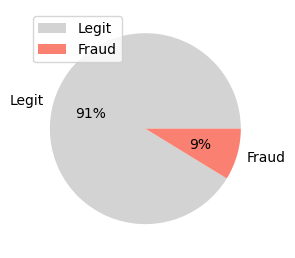

In [158]:
#Visual raw data distribution 
colors = ['lightgrey','salmon']
fraud_df.plot(kind='pie', subplots = True,autopct='%1.0f%%',colors=colors,labels = {'Legit':0,'Fraud':1},ylabel='',figsize=(3.1,3.1))

####  Aiming for an equal outcome distribution 

There's an unfair distribution between normal and fraudulent transactions. This can bias our model.

##### Separate the two classes 

In [159]:
# separating the normal transactions
legit = card_df[card_df.fraud == 0]

#look for some statistical info about normal transactions
legit.distance_from_home.describe()

count    912597.000000
mean         22.832976
std          52.828655
min           0.004874
25%           3.828942
50%           9.673847
75%          24.158057
max        8777.136420
Name: distance_from_home, dtype: float64

In [160]:
# separating the abnormal transactions
fraud = card_df[card_df.fraud == 1]

#look for some statistical info about fraudulent transactions
fraud.distance_from_home.describe()

count    87403.000000
mean        66.261876
std        134.391608
min          0.025847
25%          4.585729
50%         15.454219
75%        101.110104
max      10632.723672
Name: distance_from_home, dtype: float64

**After that, we see fraudulent transactions has a correlation with the distance.** 

We can extend this exploratory analysis for other attributes on the dataframe. We selected just one in order to eliminate distracting values.   

##### Pick an equal distribution of each class

In [161]:
legit_sample = legit.sample(n = 87403) #n is the number of random observations to make a sample set. Also n = number of fraudulent transactions

We join the now 2 balanced datasets:

**legit_sample** ---> the reduced dataset of legit transactions

**fraud** ---> dataset with fraudulent transactions

In [162]:
sample = pd.concat( [legit_sample, fraud] , axis = 0) # axis = 0 concatenate rows 

In [163]:
#saving to csv file
sample.to_csv('model_data.csv',index=False)

In [164]:
sample_table = sample.value_counts(sample['fraud'].rename(index = 'Number of cases'))

Number of cases
0.0    87403
1.0    87403
Name: count, dtype: int64

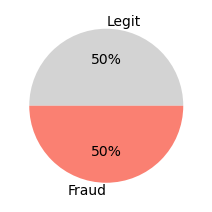

In [165]:
colors = ['lightgrey','salmon']
sample_table.plot(kind='pie',subplots = True, autopct='%1.0f%%',colors=colors,labels = {'Legit':0,'Fraud':1},ylabel='',figsize=(2.5,2.5))
sample_table

## FEATURE ENGINEERING

In [166]:
sample.corr() #correlation matrix for each feature

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
distance_from_home,1.000000,-0.015629,-0.077292,0.153788,-0.102012,-0.035530,0.056275,0.207949
distance_from_last_transaction,-0.015629,1.000000,-0.038450,-0.017520,-0.034325,-0.019225,0.021281,0.112728
ratio_to_median_purchase_price,-0.077292,-0.038450,1.000000,-0.040414,0.033723,-0.088996,0.138718,0.482165
repeat_retailer,0.153788,-0.017520,-0.040414,1.000000,-0.005347,-0.000327,0.070414,-0.002987
used_chip,-0.102012,-0.034325,0.033723,-0.005347,1.000000,0.017489,-0.024617,-0.111864
used_pin_number,-0.035530,-0.019225,-0.088996,-0.000327,0.017489,1.000000,-0.076716,-0.230403
online_order,0.056275,0.021281,0.138718,0.070414,-0.024617,-0.076716,1.000000,0.393872
fraud,0.207949,0.112728,0.482165,-0.002987,-0.111864,-0.230403,0.393872,1.000000


In [167]:
import seaborn as sns

<Axes: >

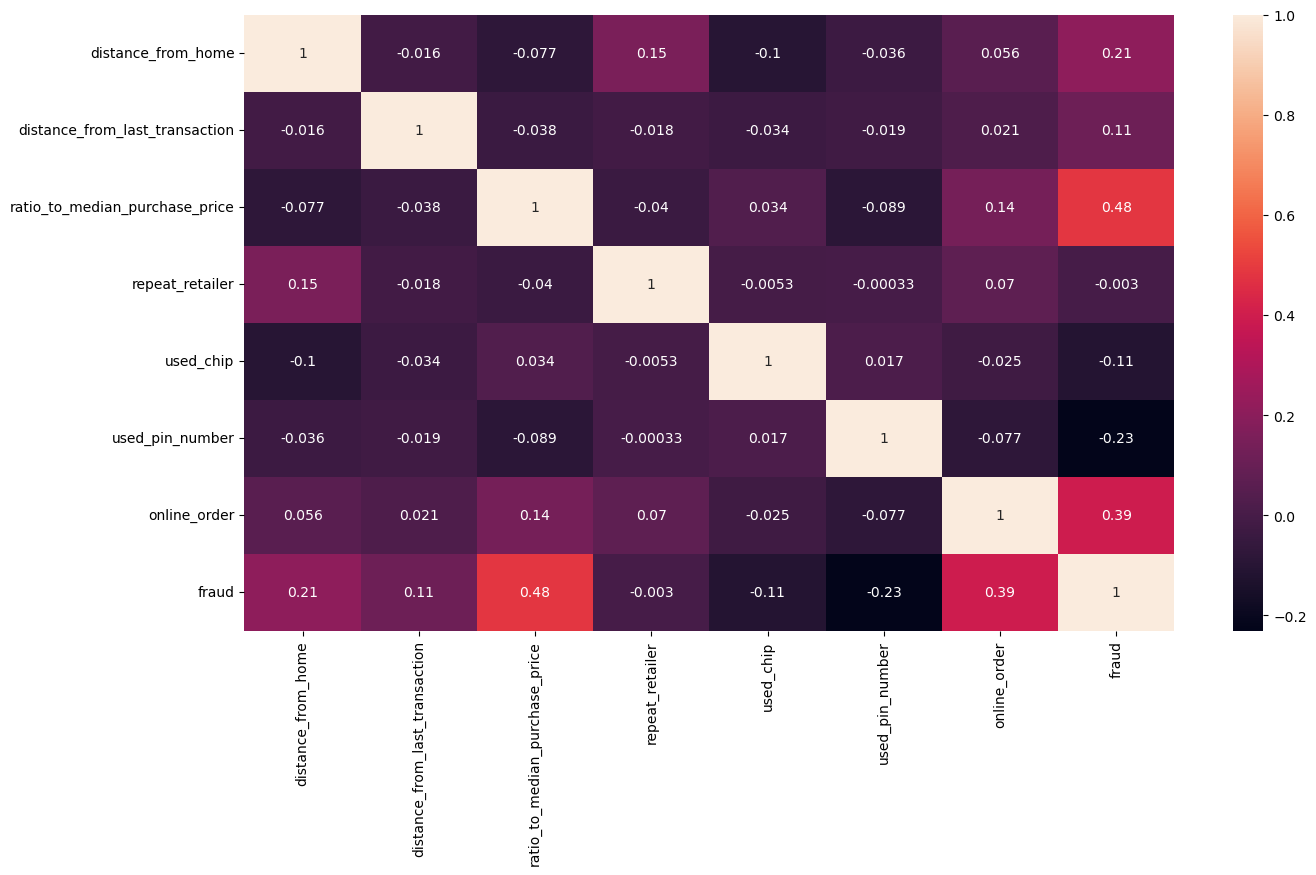

In [168]:
plt.figure(figsize=(15,8))
sns.heatmap(sample.corr(),annot=True,cmap="rocket")

**Strongly correlated features**

Positive correlation:
- distance_from_home
- distance_from_last_transaction
- ratio_to_median_purchase_price
- online_order

Negative correlation:
- used_chip
- used_pin_number

**Non-relevant features:**

- repeat_retailer


In [169]:
sample.drop(columns=['repeat_retailer'],inplace=True)

In [170]:
sample

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,used_chip,used_pin_number,online_order,fraud
279950,18.260448,0.250348,1.013625,0.0,0.0,1.0,0.0
130371,41.377303,0.350254,1.163116,1.0,1.0,0.0,0.0
726722,29.750774,3.846548,1.089020,0.0,0.0,1.0,0.0
33062,5.635743,4.895923,0.062303,1.0,0.0,0.0,0.0
409713,13.444715,1.018862,0.868877,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...
999908,45.296658,0.882736,8.856861,0.0,0.0,1.0,1.0
999916,167.139756,0.282253,0.308468,0.0,0.0,1.0,1.0
999919,124.640118,0.004416,0.434885,0.0,0.0,1.0,1.0
999939,51.412900,3.429330,29.914254,0.0,0.0,1.0,1.0


#### 4. Standardization

This process prepares our data in such a way that the mean is zero. This sets our values within the range [-1,1] preventing extreme values from weighting more in our model.  

In [171]:
# allows us to standardize our data.
from sklearn import preprocessing 

#### Understanding the process

When setting our model, we need some input data called independent variables. But we also need to define what would be the expected outcome. The variable we would like to predict, categorize or cluster is called the dependent variable.  

In [172]:
ind_var = sample.drop(columns='fraud',axis=1)

In [173]:
transform = preprocessing.StandardScaler()  # performs the standardization.

X = transform.fit_transform(ind_var) #Independent variables should go on the x-axis.
X

array([[-0.2535915 , -0.22181111, -0.56837423, -0.66721759, -0.24396762,
         0.5243933 ],
       [-0.03131983, -0.21912915, -0.53691914,  1.49876144,  4.09890453,
        -1.90696564],
       [-0.14311048, -0.12527084, -0.55250995, -0.66721759, -0.24396762,
         0.5243933 ],
       ...,
       [ 0.76926335, -0.22841318, -0.69014994, -0.66721759, -0.24396762,
         0.5243933 ],
       [ 0.06517378, -0.13647109,  5.51275746, -0.66721759, -0.24396762,
         0.5243933 ],
       [-0.27797211, -0.17817288,  1.53488158,  1.49876144, -0.24396762,
         0.5243933 ]])

In [174]:
Y = sample['fraud'].to_numpy()
Y

array([0., 0., 0., ..., 1., 1., 1.])

#### 5. Splitting into train data and test data 

In [175]:
# Allows us to split our data into training and testing data
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [176]:
X_train, X_test, Y_train, Y_test = train_test_split (X, Y, test_size = 0.2, stratify = Y, random_state = 2)

## Logistic Regression Model

In [177]:
model = LogisticRegression()

### Model training

In [178]:
model.fit(X_train,Y_train)

LogisticRegression()

In [179]:
model.get_params(deep=True)

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

### Model evaluation

We use this method in order to predict the value for Y_train which is known, using X_train as input for our model. Then we compare it to see how accurately it performed. 

##### Training Accuracy

In [180]:
Y_train_prediction = model.predict(X_train)
training_accuracy = accuracy_score(Y_train_prediction, Y_train)

In [181]:
print("Training Accuracy: %.3f " % training_accuracy)

Training Accuracy: 0.941 


#### **TEST ACCURACY**

In [182]:
Y_test_prediction = model.predict(X_test)
testing_accuracy = accuracy_score(Y_test_prediction, Y_test)

In [183]:
print("Test Accuracy: %.3f " % testing_accuracy)

Test Accuracy: 0.941 


Our **accuracy is similar** for both train and test data.

- Train accuracy >> Test accuracy implies an Overfitted model.
- Train accuracy << Test accuracy implies an Underfitted model.

##### Confusion Matrix

In [184]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [185]:
cm = confusion_matrix(Y_test,Y_test_prediction, labels = model.classes_)

In [186]:
displayCM = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['legit','fraud'])

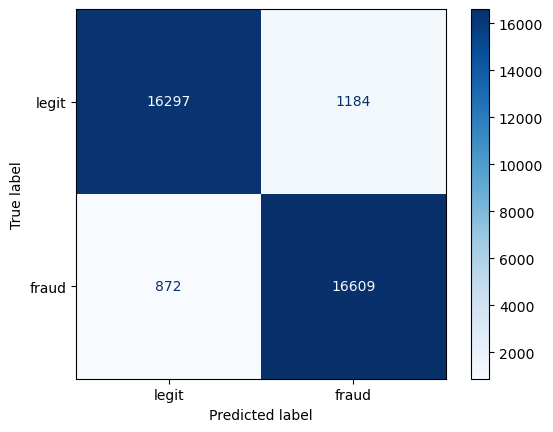

In [187]:
displayCM.plot(cmap='Blues') #plot the confusion matrix changing the color scale

#

# Model Optimization

In [188]:
from sklearn.model_selection import GridSearchCV